In [1]:
# patch bug in Teaspoon's `teaspoon.parameter_selection.MsPE`
# can cause a reference error by not defining the delay peak

from teaspoon.parameter_selection import MsPE
from PATCH_MsPE_tau import MsPE_tau
MsPE.MsPE_tau = MsPE_tau

In [2]:
# patch bug in Teaspoon's `teaspoon.TDA.PHN.DistanceMatrix`
# can crash when the input graph is not connected

from teaspoon.TDA import PHN
from PATCH_DistanceMatrix import DistanceMatrix
PHN.DistanceMatrix = DistanceMatrix

In [3]:
import numpy as np
from teaspoon.SP.network import ordinal_partition_graph
from teaspoon.SP.network import knn_graph
from teaspoon.SP.network import ordinal_partition_graph
from gtda.time_series import takens_embedding_optimal_parameters
from teaspoon.SP.network_tools import remove_zeros
from teaspoon.TDA.PHN import PH_network
from teaspoon.TDA.PHN import point_summaries
from trajectories import generate_trajectories
from plots_and_correlates import plot_lce_estimate_and_correlation


In [4]:
import ipyparallel as ipp
clients = ipp.Client()
dv = clients.direct_view()
lbv = clients.load_balanced_view()

In [5]:
SEED = 42
SAMPLES = 500
LENGTHS = [1000, 750, 500]
experimental_data_all = {}
for length in LENGTHS:
    experimental_data_all |= {
        (SEED, length, SAMPLES): generate_trajectories(
            RANDOM_SEED=SEED, TS_LENGTH=length, CONTROL_PARAM_SAMPLES=SAMPLES
        )
    }


Experiment config -- SEED:42, LENGTH:1000, SAMPLES:500
Experiment config -- SEED:42, LENGTH:750, SAMPLES:500
Experiment config -- SEED:42, LENGTH:500, SAMPLES:500


In [6]:
experimental_data = experimental_data_all[42, 1000, 500]

In [7]:
logistic_trajectories = experimental_data["logistic"]["trajectories"]
logistic_lces = experimental_data["logistic"]["lces"]
logistic_control_params = experimental_data["logistic"]["sys_params"]

In [8]:
henon_trajectories = experimental_data["henon"]["trajectories"]
henon_lces = experimental_data["henon"]["lces"]
henon_control_params = experimental_data["henon"]["sys_params"]

In [9]:
ikeda_trajectories = experimental_data["ikeda"]["trajectories"]
ikeda_lces = experimental_data["ikeda"]["lces"]
ikeda_control_params = experimental_data["ikeda"]["sys_params"]

In [10]:
tinkerbell_trajectories = experimental_data["tinkerbell"]["trajectories"]
tinkerbell_lces = experimental_data["tinkerbell"]["lces"]
tinkerbell_control_params = experimental_data["tinkerbell"]["sys_params"]

In [12]:
def get_best_params(ts, max_delay=50, max_dim=8):
    delay, dim = takens_embedding_optimal_parameters(ts, max_delay, max_dim)
    return delay, dim

In [13]:
def generate_tda_estimates(
    sys_name,
    param_name,
    trajectories,
    control_params,
    actual_lces,
    show_plot=True,
    compute_knn=True,
    compute_opn=True,
):
    # store results to be returned
    correlations = {}

    # embedding required for k-NN graph representation
    optimal_embedding_params = [
        takens_embedding_optimal_parameters(ts, max_dimension=8, max_time_delay=50)
        for ts in trajectories
    ]

    if compute_knn:
        # compute the k-NN graphs
        knn_graphs = []
        for ts, embed in zip(trajectories, optimal_embedding_params):
            tau, dim = embed
            graph = knn_graph(ts, n=dim, tau=tau, k=4)  # k=4 in original paper
            graph = remove_zeros(graph)
            knn_graphs.append(graph)

        # from graphs compute the persistence diagrams
        distance_matrices = lbv.map_sync(DistanceMatrix, knn_graphs)  # ipyparallel
        knn_diagrams = lbv.map_sync(PH_network, distance_matrices)  # ipyparallel

        # from diagrams compute the point summary statistics
        knn_stats = np.array(
            [point_summaries(diagram, A) for diagram, A in zip(knn_diagrams, knn_graphs)]
        )
        knn_stats = np.nan_to_num(knn_stats)
        (
            max_persistence_ratio,
            persistent_entropy_normalised,
            homology_class_ratio,
        ) = knn_stats.T

        # dictionary of our k-NN based estimates
        point_summary_values = {
            "$k$-NN graph maximum persistence ratio": max_persistence_ratio,
            "$k$-NN graph persistent entropy normalised": persistent_entropy_normalised,
            "$k$-NN graph homology class ratio": homology_class_ratio,
        }

        # compute the correlations of the estimates with the actual lyapunov values
        for estimate_name, estimates in point_summary_values.items():
            sequence_length = len(trajectories[0]) - 1
            correlations[
                estimate_name, sys_name, sequence_length
            ] = plot_lce_estimate_and_correlation(
                estimate_name,
                sys_name,
                param_name,
                estimates,
                actual_lces,
                control_params,
                len(trajectories[0]) - 1,
                sharey=False,
                show_plot=show_plot,
            )

    if compute_opn:
        # compute the ordinal partition graphs
        opn_graphs = []
        for ts in trajectories:
            try:
                graph = ordinal_partition_graph(ts)
            except ValueError as err:
                message = getattr(err, "message", repr(err))
                if "negative dimensions are not allowed" in message:
                    print("WARNING: ordinal_partition_graph() tried to use a negative dimension")
                    graph = np.array([[0]])
                else:
                    raise err
            graph = remove_zeros(graph)
            opn_graphs.append(graph)

        # from graphs compute the persistence diagrams
        distance_matrices_opn = lbv.map_sync(DistanceMatrix, opn_graphs)
        opn_diagrams = lbv.map_sync(PH_network, distance_matrices_opn)

        # ensure diagrams are not empty
        opn_graphs_2d = []
        for G in opn_graphs:
            if len(G) > 0:
                opn_graphs_2d.append(G)
            else:
                opn_graphs_2d.append(np.array([[0]]))

        # from diagrams compute the point summary statistics
        knn_stats_opn = np.array(
            [point_summaries(diagram, A) for diagram, A in zip(opn_diagrams, opn_graphs_2d)]
        )
        knn_stats_opn = np.nan_to_num(knn_stats_opn)
        (
            max_persistence_ratio_opn,
            persistent_entropy_normalised_opn,
            homology_class_ratio_opn,
        ) = knn_stats_opn.T

        # dictionary of our ordinal partition based estimates
        point_summary_values_opn = {
            "Ordinal graph maximum persistence ratio": max_persistence_ratio_opn,
            "Ordinal graph persistent entropy normalised": persistent_entropy_normalised_opn,
            "Ordinal graph homology class ratio": homology_class_ratio_opn,
        }

        # compute the correlations of the estimates with the actual lyapunov values
        for estimate_name, estimates in point_summary_values_opn.items():
            sequence_length = len(trajectories[0]) - 1
            correlations[
                estimate_name, sys_name, sequence_length
            ] = plot_lce_estimate_and_correlation(
                estimate_name,
                sys_name,
                param_name,
                estimates,
                actual_lces,
                control_params,
                len(trajectories[0]) - 1,
                sharey=False,
                show_plot=show_plot,
            )

    return correlations


ordinal_partition_graph() tried to use a negative dimension


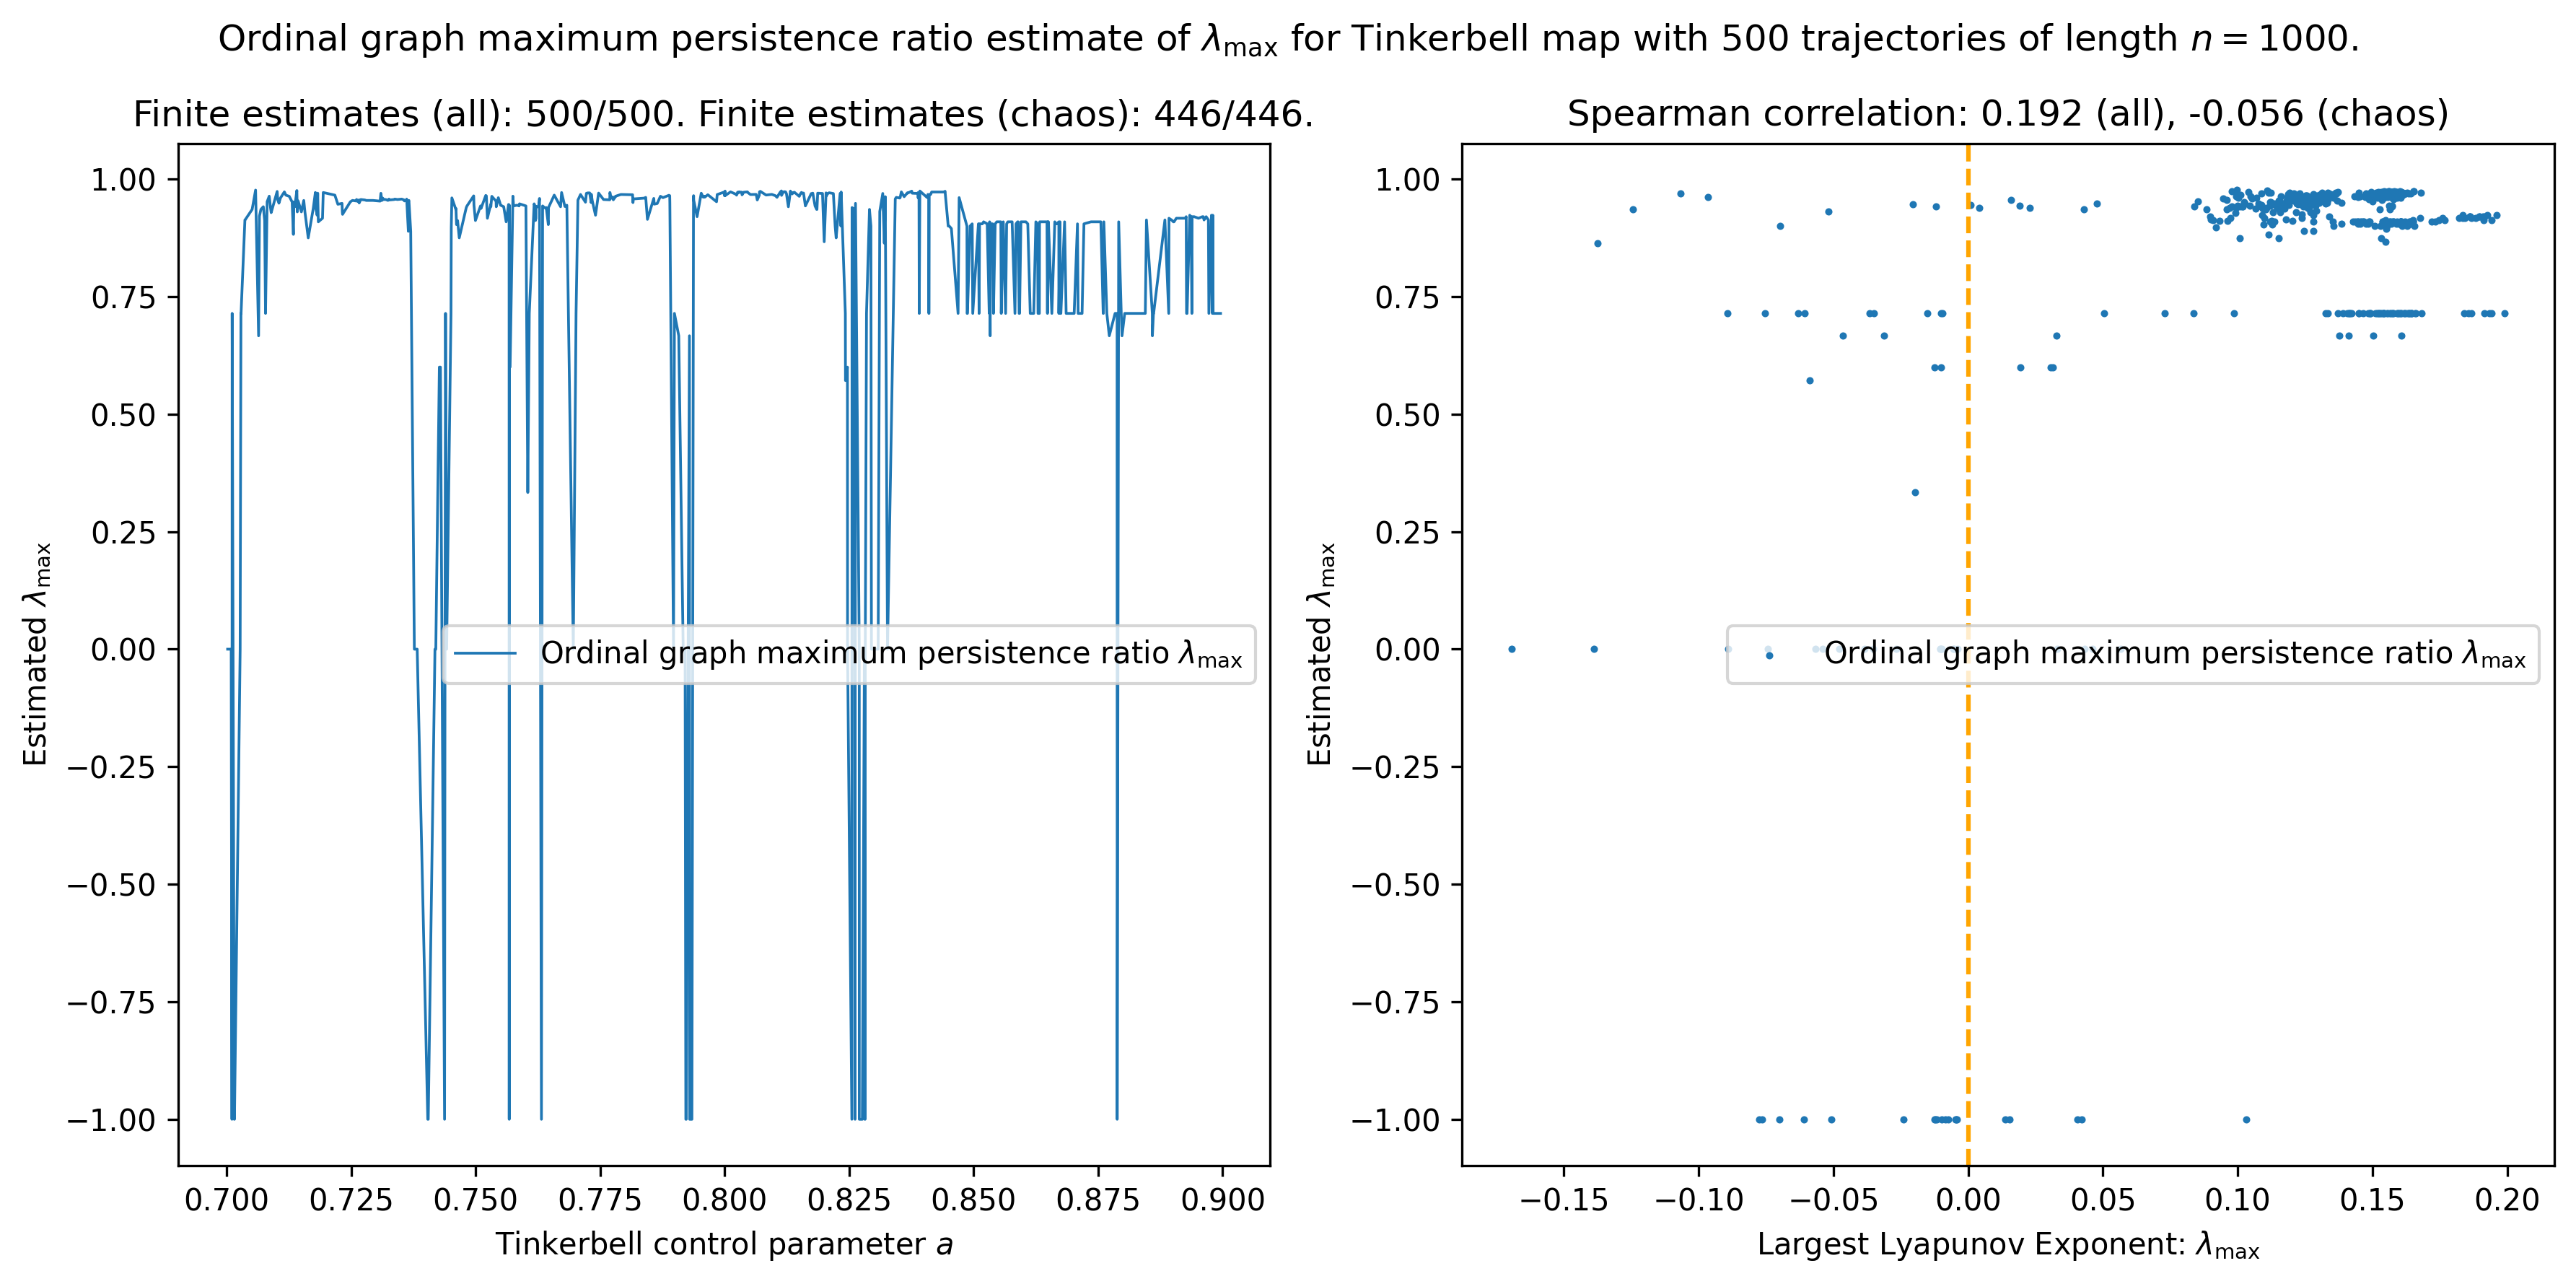

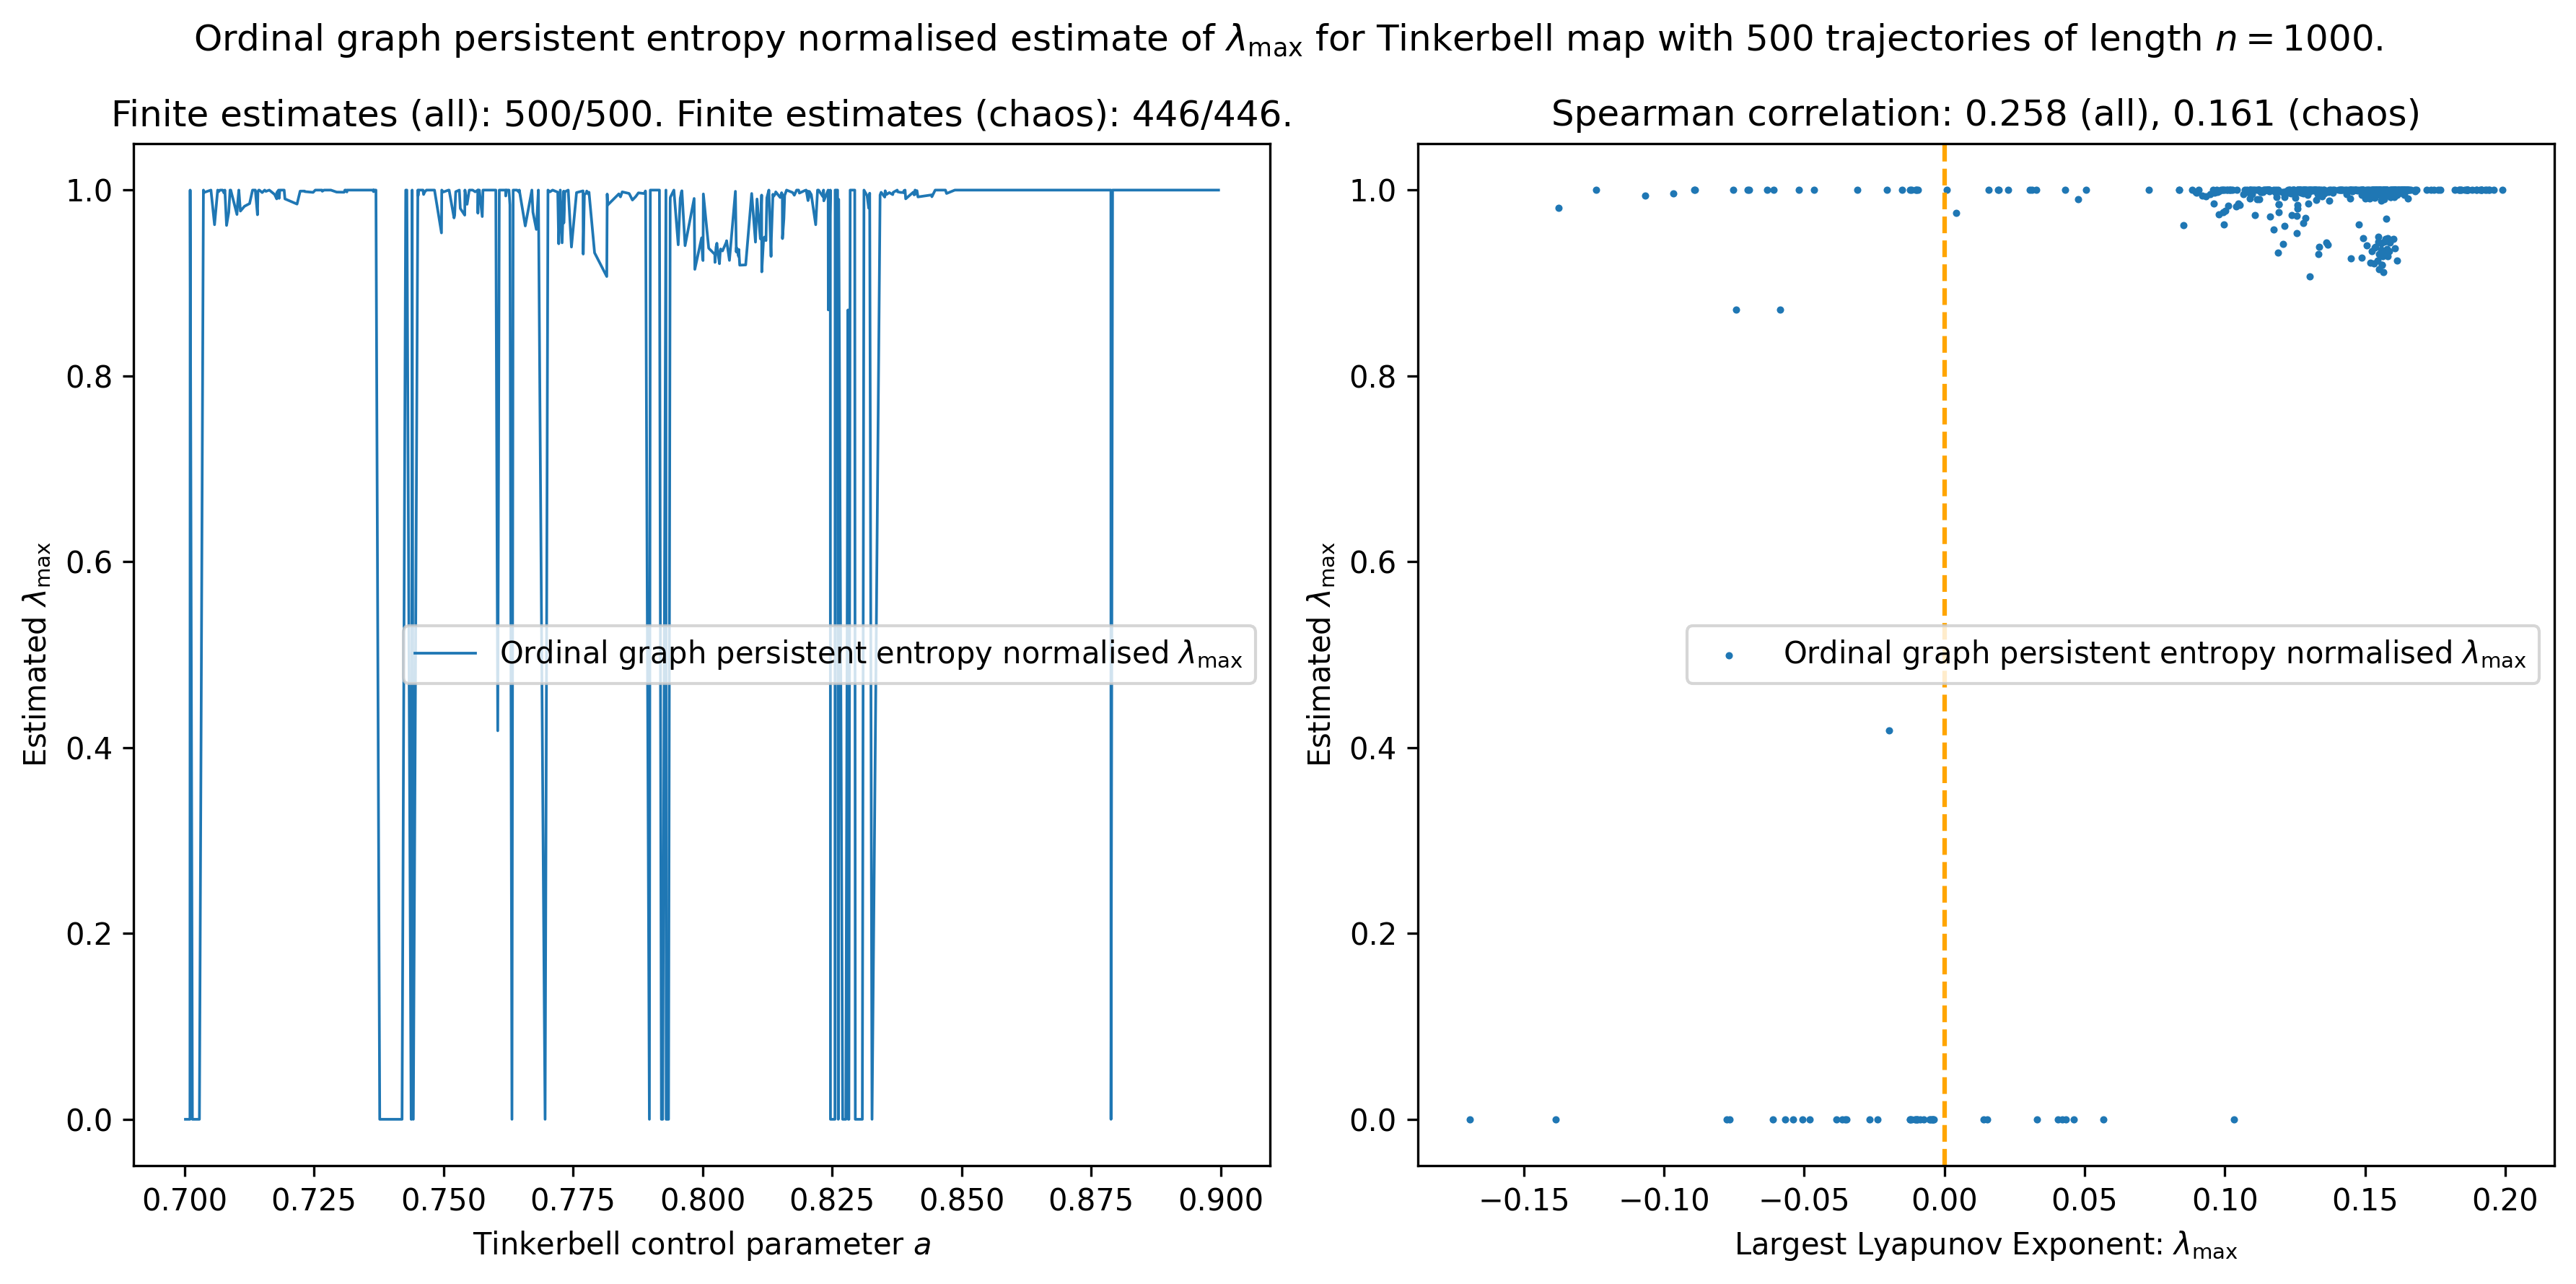

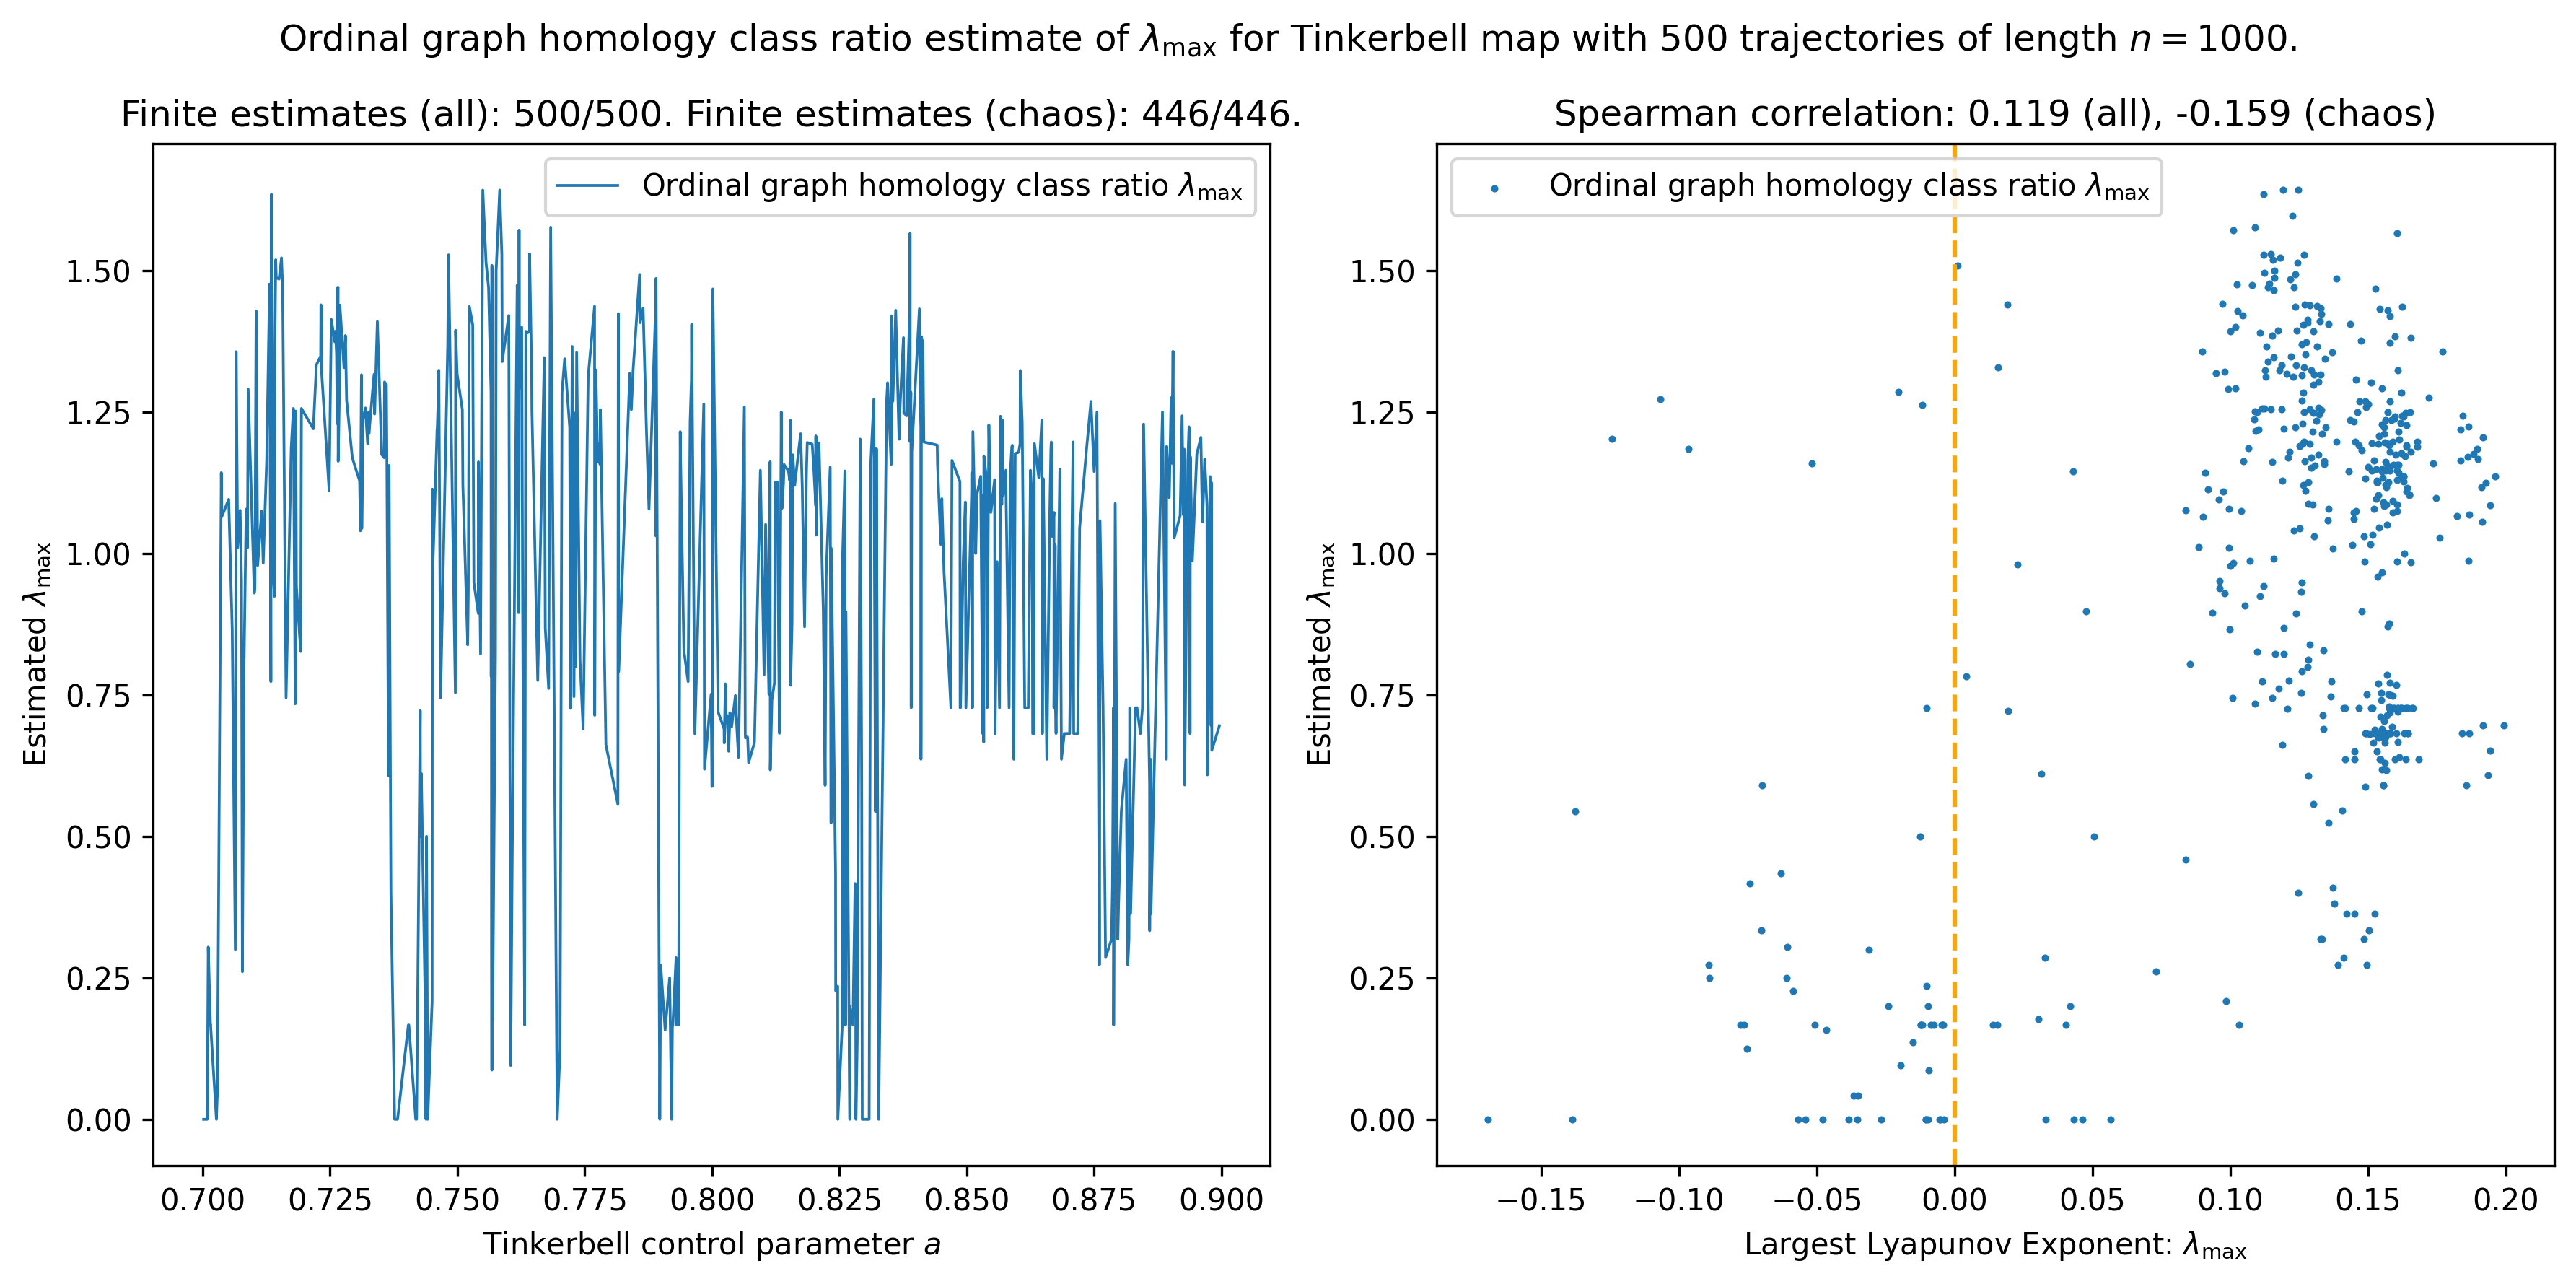

In [14]:
all_results = {}
for sys_info in [
    ["Logistic", "r", logistic_trajectories, logistic_control_params, logistic_lces],
    ["Hénon", "a", henon_trajectories, henon_control_params, henon_lces],
    ["Tinkerbell", "a", tinkerbell_trajectories, tinkerbell_control_params, tinkerbell_lces],
    ["Ikeda", "a", ikeda_trajectories, ikeda_control_params, ikeda_lces],
]:
    all_results |= generate_tda_estimates(*sys_info)

In [ ]:
all_results